In [1]:
import numpy as np
from matplotlib import pyplot as plt

import pandas as pd

import random
import os
import cv2
from sklearn.metrics import roc_curve, auc


import sys
sys.path.append('../scripts')
from utils import *

#data from here http://weegee.vision.ucmerced.edu/datasets/landuse.html

In [2]:
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1)

def get_curves(labels, n_out: int, trials: list = [0], pca_type: str = 'pca', base_dir: str = 'results', fl_type: str = ''):
    if len(fl_type) > 0:
        fl_type = f'{fl_type}_'

    fprs = []
    tprs = []
    for trial in trials:
        pca_preds = np.load(f'./{base_dir}/{pca_type}/preds_{fl_type}{n_out}_t{trial}.npy')

        fpr, tpr, _ = roc_curve(labels, pca_preds, drop_intermediate=False)
        fprs.append(fpr)
        tprs.append(tpr)

    fpr = tolerant_mean(fprs)
    tpr = tolerant_mean(tprs)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc

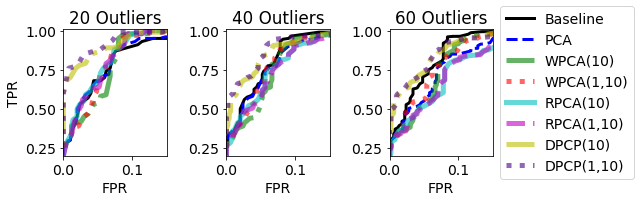

In [14]:


trials = [0,1,2,3,4]
face_num = 1
linestyles = ['solid', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1, 1, 1, 1, 1))]
colors = ['k','b', 'g', 'r', 'c', 'm', 'y', 'indigo', 'maroon', 'teal', 'orange', 'purple', 'brown']

n_in = 100
fl_types = [[10], [1,10]]
fl_ids = ['(10)', '(1,10)']

fig, axs = plt.subplots(1,3, figsize = (9,3))
jj=0
for n_out in [20,40,60]: #,80,100]: #,64,128]:
    labels = [0]*n_in + [1]*n_out  
    ii=0
    axs[jj].set_title(f'{n_out} Outliers')
    fpr, tpr, roc_auc = get_curves(labels, n_out, trials, 'pca_all')
    axs[jj].plot(fpr, tpr, lw = 3, color = colors[ii], linestyle = linestyles[ii], label = f'Baseline')# (AUC = {np.round(roc_auc,2)})')
    ii+=1

    fpr, tpr, roc_auc = get_curves(labels, n_out, trials, 'pca')
    axs[jj].plot(fpr, tpr, lw = 3, color = colors[ii], linestyle = linestyles[ii], label = f'PCA')# (AUC = {np.round(roc_auc,2)})')
    ii+=1
    
    for fl_type, fl_id in zip(fl_types, fl_ids):

        fpr, tpr, roc_auc = get_curves(labels, n_out, trials, 'wpca', fl_type = fl_type)
        axs[jj].plot(fpr, tpr, alpha = .6, lw = 5, color = colors[ii], linestyle = linestyles[ii], label = f'WPCA{fl_id}')# (AUC = {np.round(roc_auc,2)})')
        ii+=1

    for fl_type, fl_id in zip(fl_types, fl_ids):

        fpr, tpr, roc_auc = get_curves(labels, n_out, trials, 'rpca', fl_type = fl_type)
        axs[jj].plot(fpr, tpr, alpha = .6, lw = 5, color = colors[ii], linestyle = linestyles[ii], label = f'RPCA{fl_id}')# (AUC = {np.round(roc_auc,2)})')
        ii+=1
    
    for fl_type, fl_id in zip(fl_types, fl_ids):
        
        fpr, tpr, roc_auc = get_curves(labels, n_out, trials, 'dpcp', fl_type = fl_type)
        axs[jj].plot(fpr, tpr, alpha = .6, lw = 5, color = colors[ii], linestyle = linestyles[ii], label = f'DPCP{fl_id}')# (AUC = {np.round(roc_auc,2)})')    
        ii+=1

    
    axs[jj].set_xlabel('FPR')

    axs[jj].set_xlim([0,.15])
    axs[jj].set_ylim([.2,1.01])

    


    jj+=1

axs[0].set_ylabel('TPR')

axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
plt.tight_layout()
plt.savefig('landuse_roc.pdf')

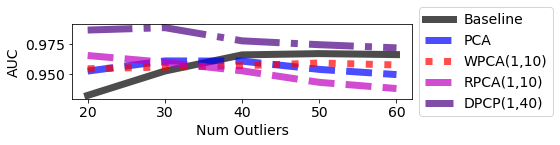

In [13]:
res = pd.DataFrame(columns = ['Num Outliers', 'Algorithm', 'AUC'])

trials = [0,1,2,3,4]
face_num = 1
linestyles = ['solid', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1, 1, 1, 1, 1))]
colors = ['k','b', 'g', 'r', 'c', 'm', 'y', 'indigo', 'maroon', 'teal', 'orange', 'purple', 'brown']

n_in = 100
fl_types = [[10], [1,10]]
fl_ids = ['(10)', '(1,10)']

# fig, axs = plt.subplots(1,3, figsize = (9,3))
jj=0
for n_out in [20,30,40,50,60]: #,80,100]: #,64,128]:
    labels = [0]*n_in + [1]*n_out  
    ii=0
    # axs[jj].set_title(f'{n_out} Outliers')
    fpr, tpr, roc_auc = get_curves(labels, n_out, trials, 'pca_all')
    # axs[jj].plot(fpr, tpr, lw = 3, color = colors[ii], linestyle = linestyles[ii], label = f'Baseline')# (AUC = {np.round(roc_auc,2)})')
    row = pd.DataFrame(columns = res.columns, data = [[n_out, 'PCA All', roc_auc]])
    res = pd.concat([res, row])
    ii+=1

    fpr, tpr, roc_auc = get_curves(labels, n_out, trials, 'pca')
    # axs[jj].plot(fpr, tpr, lw = 3, color = colors[ii], linestyle = linestyles[ii], label = f'PCA')# (AUC = {np.round(roc_auc,2)})')
    row = pd.DataFrame(columns = res.columns, data = [[n_out, 'PCA', roc_auc]])
    res = pd.concat([res, row])
    ii+=1
    
    for fl_type, fl_id in zip(fl_types, fl_ids):

        fpr, tpr, roc_auc = get_curves(labels, n_out, trials, 'wpca', fl_type = fl_type)
        # axs[jj].plot(fpr, tpr, alpha = .6, lw = 5, color = colors[ii], linestyle = linestyles[ii], label = f'WPCA{fl_id}')# (AUC = {np.round(roc_auc,2)})')
        row = pd.DataFrame(columns = res.columns, data = [[n_out, f'WPCA{fl_type}', roc_auc]])
        res = pd.concat([res, row])
        ii+=1

    for fl_type, fl_id in zip(fl_types, fl_ids):

        fpr, tpr, roc_auc = get_curves(labels, n_out, trials, 'rpca', fl_type = fl_type)
        # axs[jj].plot(fpr, tpr, alpha = .6, lw = 5, color = colors[ii], linestyle = linestyles[ii], label = f'RPCA{fl_id}')# (AUC = {np.round(roc_auc,2)})')
        row = pd.DataFrame(columns = res.columns, data = [[n_out, f'RPCA{fl_type}', roc_auc]])
        res = pd.concat([res, row])
        ii+=1
    
    for fl_type, fl_id in zip(fl_types, fl_ids):
        
        fpr, tpr, roc_auc = get_curves(labels, n_out, trials, 'dpcp', fl_type = fl_type)
        # axs[jj].plot(fpr, tpr, alpha = .6, lw = 5, color = colors[ii], linestyle = linestyles[ii], label = f'DPCP{fl_id}')# (AUC = {np.round(roc_auc,2)})')
        row = pd.DataFrame(columns = res.columns, data = [[n_out, f'DPCP{fl_type}', roc_auc]])
        res = pd.concat([res, row])        
        ii+=1

    
    # axs[jj].set_xlabel('FPR')

    # axs[jj].set_xlim([0,.15])
    # axs[jj].set_ylim([.2,1.01])

    


    jj+=1

# axs[0].set_ylabel('TPR')

# axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
# plt.tight_layout()
# plt.savefig('landuse_roc.pdf')

colors = ['k', 'b',  'r', 'm', 'indigo']
linestyles = ['solid', '--',  ':', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1, 1, 1, 1, 1))]

plt.rcParams.update({'font.size': 14})
plt.figure(figsize = (8,2))

ii=0
for alg, alg_lbl in zip(['PCA All','PCA',  'WPCA[1, 10]', 'RPCA[1, 10]', 'DPCP[1, 10]'], ['Baseline', 'PCA',  'WPCA(1,10)', 'RPCA(1,10)', 'DPCP(1,40)']):
    if str([10]) not in alg:
        idx = res['Algorithm'] == alg
        sel_res = res[idx]
        plt.plot(sel_res['Num Outliers'].values, sel_res['AUC'].values, label = alg_lbl, lw = 7, alpha = .7, color = colors[ii], linestyle = linestyles[ii])
        ii+=1
# plt.ylim([.8, 1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
plt.ylabel('AUC')
plt.xlabel('Num Outliers')
plt.tight_layout()
plt.savefig('landuse_auc.pdf')


In [4]:
sel_res['Num Outliers'].values

array([20, 40, 60], dtype=object)

In [ ]:

trials = [0,1,2,3,4]
face_num = 1
linestyles = ['solid', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1, 1, 1, 1, 1))]
n_in = 100
fl_types = [[1,10], [10]]

for n_out in [20,40,60,80,100]: #,64,128]:
    labels = [0]*n_in + [1]*n_out

    
    ii=0
    plt.figure(figsize = (8,4))
    plt.title(f'{n_out} Outliers')
    fpr, tpr, roc_auc = get_curves(labels, n_out, trials, 'pca_all')
    plt.plot(fpr, tpr, lw = 3, linestyle = linestyles[ii], label = f'PCA All (AUC = {np.round(roc_auc,2)})', color = 'k')


    fpr, tpr, roc_auc = get_curves(labels, n_out, trials, 'pca')
    plt.plot(fpr, tpr, lw = 3, linestyle = linestyles[ii], label = f'PCA (AUC = {np.round(roc_auc,2)})')
    ii+=1



    for fl_type in fl_types:

        fpr, tpr, roc_auc = get_curves(labels, n_out, trials, 'rpca', fl_type = fl_type)
        plt.plot(fpr, tpr, alpha = .7, lw = 3, linestyle = linestyles[ii], label = f'RPCA{fl_type} (AUC = {np.round(roc_auc,2)})')
        ii+=1

        fpr, tpr, roc_auc = get_curves(labels, n_out, trials, 'wpca', fl_type = fl_type)
        plt.plot(fpr, tpr, alpha = .7, lw = 3, linestyle = linestyles[ii], label = f'WPCA{fl_type} (AUC = {np.round(roc_auc,2)})')
        ii+=1
        
        fpr, tpr, roc_auc = get_curves(labels, n_out, trials, 'dpcp', fl_type = fl_type)
        plt.plot(fpr, tpr, alpha = .7, lw = 3, linestyle = linestyles[ii], label = f'DPCP{fl_type} (AUC = {np.round(roc_auc,2)})')
        ii+=1

    plt.ylabel('TPR')
    plt.xlabel('FPR')

    plt.legend()
